# Creating a Model to put Googly Eyes on top of Eyes

FunnyFaces has recognized my talent and accepted to work with me for their game changing product - *GaaS* as in GoolyEyezer as a Service!

This is a service that receives photos (of people) and put googly eyes on top of people eyes!

To approach this feature, I am going to start with a baseline using OpenCVs Haar Cascade Model.

## Iteration 1: Haars Cascade Model

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, ["Rapid Object Detection using a Boosted Cascade of Simple Features"](https://ieeexplore.ieee.org/document/990517) in 2001.
It is a machine learning based approach where a cascade function is trained from a lot of positive (the object you want to detect) and negative (object that are not the one you want to detect) images. It is then used to detect objects in other images.

OpenCV already has an Haars Cascade Model trained with faces with the hability to detect eyes.

For this eyes detection capacity, the Model uses Haar features that are shown in the below image are used. 

![Visualizing Haar Features](https://docs.opencv.org/3.4/haar_features.jpg)


They are just like a convolutional kernel. Each feature is a single value obtained by subtracting sum of pixels under the white rectangle from sum of pixels under the black rectangle.
Now, all possible sizes and locations of each kernel are used to calculate lots of features. (Just imagine how much computation it needs? Even a 24x24 window results over 160000 features).

But among all these features we calculated, most of them are irrelevant. For example, consider the image below. 

![Example for Feature Kernel](https://docs.opencv.org/3.4/haar.png)


The top row shows two good features. The first feature selected seems to focus on the property that the region of the eyes is often darker than the region of the nose and cheeks. The second feature selected relies on the property that the eyes are darker than the bridge of the nose. But the same windows applied to cheeks or any other place is irrelevant. So how do we select the best features out of 160000+ features? It is achieved by Adaboost.


The final classifier is a weighted sum of these weak classifiers. It is called weak because it alone can't classify the image, but together with others forms a strong classifier







In [1]:
import cv2
import imutils
import numpy as np
import random
from matplotlib import pyplot as plt

In [14]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [15]:
googly_eye = cv2.imread('./googly_eye_tr.png', cv2.IMREAD_UNCHANGED)

In [18]:
random.seed(125)

In [19]:
img = cv2.imread('...')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 8)
for (x,y,w,h) in faces:
    #img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray, 1.3, 5)
    for (ex,ey,ew,eh) in eyes:
        eye = cv2.resize(googly_eye.copy(), (ew, eh))
        eye = imutils.rotate(eye, int(360*random.random()))
        rows,cols,channels = eye.shape
        b,g,r,a = cv2.split(eye)
        overlay_color = cv2.merge((b,g,r))
        
        mask = cv2.medianBlur(a,5)
        h, w, _ = overlay_color.shape
        
        img_eye_roi = roi_color[ey:ey+cols, ex:ex+rows]
        
        img1_bg = cv2.bitwise_and(img_eye_roi.copy(),img_eye_roi.copy(),mask = cv2.bitwise_not(mask))
        img2_fg = cv2.bitwise_and(overlay_color,overlay_color,mask = mask)
        
        roi_color[ey:ey+ew, ex:ex+eh] = cv2.add(img1_bg, img2_fg)
        #cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)


In [ ]:
cv2.imshow('img',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [8]:
#https://gist.github.com/clungzta/b4bbb3e2aa0490b0cfcbc042184b0b4e
#https://stackoverflow.com/questions/40895785/using-opencv-to-overlay-transparent-image-onto-another-image
#https://github.com/fatcat2/googly-eyes/blob/master/Python/piceyefilters.py

### What can we expect from this model?

Here are two examples examples for model performance:


In [9]:
from io import BytesIO
import urllib

class GooglyEyezer:
    def __init__(self, googly_eyes_path_image: str = "./googly_eye_tr.png"):
        self.face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
        )
        self.eye_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + "haarcascade_eye.xml"
        )
        self.googly_eye_path_image = googly_eyes_path_image
        self.googly_eye = cv2.imread(googly_eyes_path_image, cv2.IMREAD_UNCHANGED)

    def apply(
        self,
        image_stream: BytesIO,
        image_encode: str = "jpg",
        eyes_rotation_randomize_seed=12345,
    ) -> BytesIO:
        image_stream.seek(0)
        file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
        img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        faces = self.face_cascade.detectMultiScale(gray, 1.3, 8)

        for (x, y, w, h) in faces:
            roi_gray = gray[y : y + h, x : x + w]
            roi_color = img[y : y + h, x : x + w]
            eyes = self.eye_cascade.detectMultiScale(roi_gray, 1.3, 5)
            for (ex, ey, ew, eh) in eyes:
                eye = cv2.resize(self.googly_eye.copy(), (ew, eh))
                eye = imutils.rotate(eye, int(360 * random.random()))
                rows, cols, channels = eye.shape
                b, g, r, a = cv2.split(eye)
                overlay_color = cv2.merge((b, g, r))

                mask = cv2.medianBlur(a, 5)
                h, w, _ = overlay_color.shape

                img_eye_roi = roi_color[ey : ey + cols, ex : ex + rows]

                img1_bg = cv2.bitwise_and(
                    img_eye_roi.copy(), img_eye_roi.copy(), mask=cv2.bitwise_not(mask)
                )
                img2_fg = cv2.bitwise_and(overlay_color, overlay_color, mask=mask)

                roi_color[ey : ey + ew, ex : ex + eh] = cv2.add(img1_bg, img2_fg)

        is_success, im_buf_arr = cv2.imencode(f".{image_encode}", img)
        if is_success:
            return BytesIO(im_buf_arr)
        raise Exception("Unable to encode image")

In [19]:
def image_url_to_bytes(image_url: str) -> BytesIO:
    image_url_strip = image_url.strip()
    url = urllib.request.urlopen(image_url_strip)
    return BytesIO(url.read())

In [13]:
def plot_image_bytes(image_stream: BytesIO):
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_im)
    plt.title('my picture')
    plt.show()

In [36]:
images = ["https://www.iom.int/sites/default/files/press_release/media/pbn_02152018_UNICEF%20Call%20to%20Action2.png",
 "http://static01.nyt.com/images/2019/10/02/video/02-still-for-america-room-loop/02-still-for-america-room-loop-superJumbo.jpg",
 "http://media.gettyimages.com/photos/elon-musk-founder-of-spacex-speaks-during-the-satellite-2020-at-the-picture-id1206290117?s=2048x2048",
 "https://blog.aaainovacao.com.br/wp-content/uploads/2020/11/Jack_Ma-1.jpg"]

#### Original Images

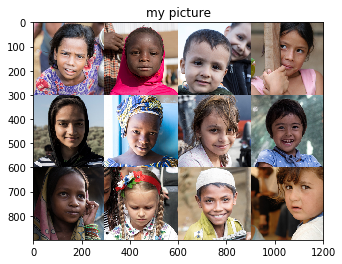

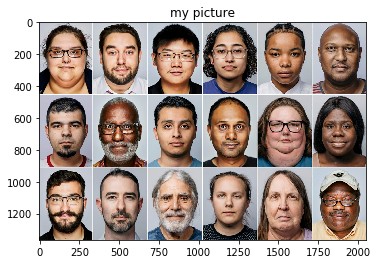

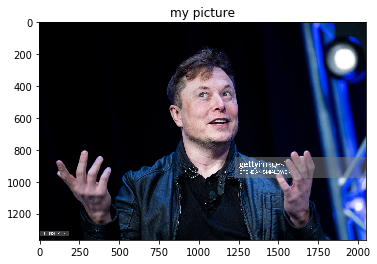

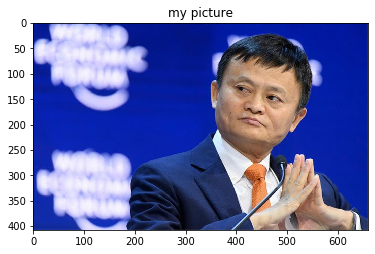

In [37]:
urls = map(image_url_to_bytes, images)
plot_images = [plot_image_bytes(image_bytes) for image_bytes in urls]

#### Googlyeyezed Images

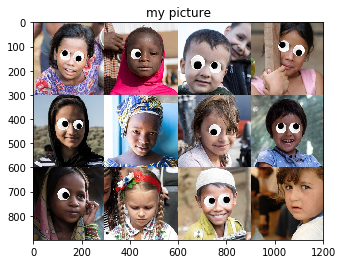

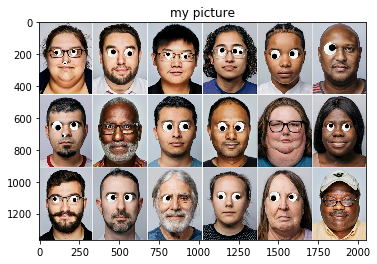

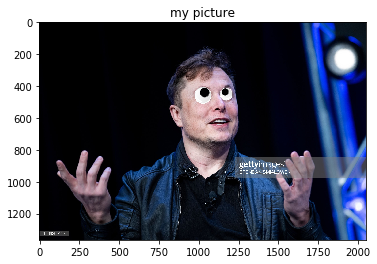

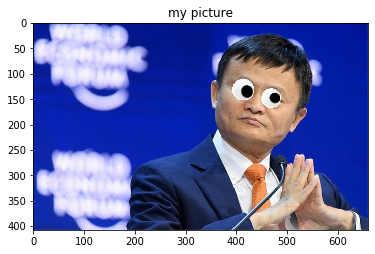

In [38]:
googlyeyezer = GooglyEyezer()

urls = map(image_url_to_bytes, images)
image_googlyeyez_bytes = map(lambda x: googlyeyezer.apply(x), urls)
plot_images = [plot_image_bytes(image_bytes) for image_bytes in image_googlyeyez_bytes]